In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

SyntaxError: incomplete input (<ipython-input-1-583db37e43a6>, line 17)

In [2]:
import numpy as np
import os
import glob
import time

# importing data
event_types = {1:'UNCERT',2:'UNRELOC'}

train_dir = os.path.join('/kaggle/input/dcl-uncert/DCL_uncert/train')

# Replace 'your_search_string' with the string you are looking for in file names
search_string = 'bn'

search_pattern = os.path.join(train_dir, f'*{search_string}*')
train_files = glob.glob(search_pattern)
import json

json_data_path = '/kaggle/input/dcl-uncert/DCL_uncert/params.json'
with open(json_data_path, 'r') as file:
    try:
        json_data = json.load(file)
        print(json_data)
    except json.JSONDecodeError:
        print(f"Error: JSON decode failed for file '{file_path}'")

dno = json_data['number of data points']

try:
    chrn = len(json_data['channel ranges'])
except:
    chrn = 1
    
try:
    t = json_data['time interval'][1]-json_data['time interval'][0]
except:
    t='n/a'
    
# Calculating the number of points in each binnning
bin_list = json_data['bin list']
dno_list = (chrn * len(bin_list)) * [dno]
data_total = sum(dno_list)
check_data = np.loadtxt(train_files[1], delimiter='\t').astype(np.int32)
len_data = len(check_data)
print(dno_list)

if data_total == len_data and len(dno_list) == len(bin_list) * chrn:
    print('\nbin edges calculated correctly')
else:
    print('inconsistency in bin edges calculated and data')
    print(data_total)
    print(len_data)
    
print('\nchannel range no',chrn)
print('number of data points',dno)
print('time interval',t)

import numpy as np

def process_file_krushna(file, X, event_counter, dno_list):
    """
    Processes a single file and adds its data to the dataset.
    file: path to the file to be processed
    X: list of datasets to be appended to
    Y: list of labels of data
    event_counter: dictionary counting events
    dno_list: list of number of data points in each binning as calculated previously
    
    Returns updated X, Y, and event_counter
    """
    # Fetch data from file and check if label is considered
    event_type, event_name = file.split('/')[-1].split('_')
    loaded_data = np.loadtxt(file, delimiter='\t').astype(np.int32)
    
    if event_type not in event_counter:
        print("returning")
        return X, event_counter
        
    for key, value in event_types.items():
        if value in file.split('\\')[-1]:
            event_counter[value] += 1
            
    channel_1_data = []
    channel_2_data = []

    # Initialize lists to hold data slices
    for i in range(0,len(loaded_data),998):
        channel_1_data.extend(loaded_data[i:i+499])
        channel_2_data.extend(loaded_data[i+499:i+998])
    
    X.append([channel_1_data, channel_2_data])
    
    return X, event_counter



# initializing train sets
X = []
train_event_counter = {'UNCERT':0, 'UNRELOC':0}


# print(process_file(train_files[1],X_train,Y_train,train_event_counter))

# processing train data sets
for file in train_files:
    X,train_event_counter = process_file_krushna(file,X,train_event_counter,dno_list)
print('training events\n',train_event_counter)
print('total events : ', sum([i for i in train_event_counter.values()]))
X = np.array(X)
print('shape of X', X.shape)




{'bin list': [0.001, 0.005, 0.01, 0.1, 0.5, 1, 5], 'time interval': 'n/a', 'number of data points': 499, 'data set name': 'DCL_test', 'data set path': 'C:\\Users\\arpan\\OneDrive\\Documents\\GRB\\data\\DCL_test', 'channel ranges': [[3, 50], [51, 124]], 'ratio': 0.5, 'type': 'hrates', 'include unprocessed': False}
[499, 499, 499, 499, 499, 499, 499, 499, 499, 499, 499, 499, 499, 499]

bin edges calculated correctly

channel range no 2
number of data points 499
time interval n/a
training events
 {'UNCERT': 50, 'UNRELOC': 25}
total events :  75
shape of X (75, 2, 3493)


In [3]:
import tensorflow as tf
from keras import layers, models,regularizers,Sequential
from keras.callbacks import EarlyStopping , ReduceLROnPlateau, Callback
from tensorflow.keras.optimizers import Adam
from keras.layers import Input, LSTM, GRU, Bidirectional,BatchNormalization
from keras.models import load_model

In [4]:
model_path = '/kaggle/input/rcnn/keras/default/1/RCNN.h5'
model = load_model(model_path)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 2, 512)              │       1,788,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 2, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 1, 512)              │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 1, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 1, 1024)             │       6,295,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 1024)                │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,922,310 (37.85 MB)

 Trainable params: 9,922,308 (37.85 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [5]:
Y_pred = model.predict(X)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step


In [7]:
print(Y_pred)

[[9.54291448e-02 4.50555086e-02 5.21062464e-02 8.07409167e-01]
 [7.44898105e-03 9.42765677e-04 2.57636071e-03 9.89031971e-01]
 [6.80790842e-01 4.08740938e-02 1.24961607e-01 1.53373390e-01]
 [2.17274591e-01 3.68967533e-01 1.83729649e-01 2.30028242e-01]
 [6.24919124e-02 6.33206785e-01 8.45389962e-02 2.19762385e-01]
 [4.72944044e-02 7.59942830e-01 7.34993368e-02 1.19263425e-01]
 [6.45170435e-02 6.51010513e-01 8.69984999e-02 1.97473839e-01]
 [1.57086894e-01 3.17396045e-01 1.39067277e-01 3.86449784e-01]
 [4.84345257e-02 7.57556260e-01 7.42516667e-02 1.19757451e-01]
 [2.32983497e-03 1.33034517e-03 1.26339402e-03 9.95076418e-01]
 [4.72944044e-02 7.59942830e-01 7.34993368e-02 1.19263425e-01]
 [4.72944044e-02 7.59942830e-01 7.34993368e-02 1.19263425e-01]
 [8.84265825e-03 9.47724342e-01 1.60530005e-02 2.73800120e-02]
 [1.82988822e-01 4.59196359e-01 1.45416304e-01 2.12398469e-01]
 [7.64464810e-02 7.10318863e-01 8.54487717e-02 1.27785832e-01]
 [4.72944044e-02 7.59942830e-01 7.34993368e-02 1.192634

In [18]:
import matplotlib.pyplot as plt
import numpy as np

threshold = 0.6


def predict_with_unidentified(model, data, threshold=0.6):
    predictions = model.predict(data)
    max_prob = np.max(predictions, axis=1)
    labels = np.argmax(predictions, axis=1)
    labels[max_prob < threshold] = 4
    
    unidentified_count = np.sum(max_prob < threshold)
    return labels, max_prob,unidentified_count


In [19]:
result,max_prob, count = predict_with_unidentified(model, X, threshold)
print(result)
print(count)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[3 3 0 4 1 1 1 4 1 3 1 1 1 4 1 1 1 1 1 4 1 1 1 1 4 3 1 1 0 1 4 3 1 1 1 2 1
 1 1 1 4 4 3 1 1 4 1 1 1 1 1 3 1 1 1 1 1 1 1 3 3 1 1 1 1 1 4 1 1 1 1 1 1 0
 1]
10


(array([ 1.,  2.,  0.,  1.,  0.,  3.,  0.,  3.,  2.,  2.,  3.,  4., 29.,
         2.,  3.,  2.,  1.,  0.,  3., 14.]),
 array([0.32761878, 0.36117467, 0.39473054, 0.42828643, 0.4618423 ,
        0.49539819, 0.52895409, 0.56250995, 0.59606582, 0.62962174,
        0.66317761, 0.69673347, 0.7302894 , 0.76384526, 0.79740113,
        0.83095706, 0.86451292, 0.89806879, 0.93162465, 0.96518058,
        0.99873644]),
 <BarContainer object of 20 artists>)

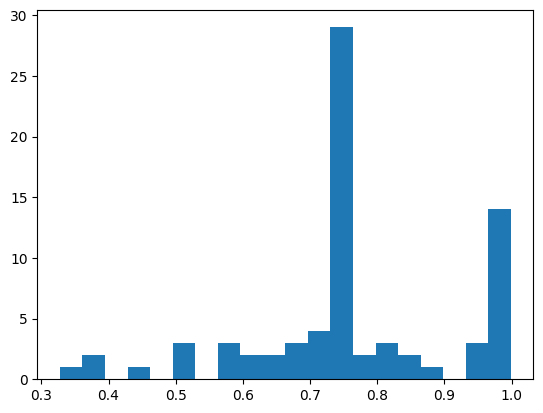

In [22]:
plt.hist(max_prob, bins = 20)